In [1]:
from trainer import Trainer
from model import CorefScorer
from loader import train_corpus, val_corpus
import torch

model = CorefScorer()
trainer = Trainer(model=model, train_corpus=train_corpus, val_corpus=val_corpus, batch_size=15, lr=1e-3)
trainer.load_model('model_weights/2022-03-07 17-19-03.pth')

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import pandas as pd
import numpy as np

In [3]:
from spacy.lang.en import English
from text import Document
nlp = English()

In [5]:
df = pd.read_excel("../data/gap/MY_DATASET.xlsx")
n = len(df) - 4

X_train = np.zeros((n,3))
y_train = np.zeros(n)

# for index, row in df.sample(frac=1).iterrows():
for index, row in df.iloc[0:n].iterrows():
    spacy_doc = nlp(row['Text'])
    doc = Document(tokens=[token.text for token in spacy_doc], speakers=["-" for token in spacy_doc],
               corefs=[], raw_text=None, filename=None, sentences=None)
    # spans, probs, g_clusters, r_clusters, p_clusters = trainer.predict_clusters(doc)
    spans, probs  = trainer.predict_clusters(doc)
    span_tokens = [(idx, doc.tokens[span.i1:span.i2 + 1]) for idx, span in enumerate(spans)]
    a_span_tokens = [span_token for span_token in span_tokens if " ".join(span_token[1]) == row["A"]][0]
    b_span_tokens = [span_token for span_token in span_tokens if " ".join(span_token[1]) == row["B"]][0]
    p_span_tokens = [span_token for span_token in span_tokens if " ".join(span_token[1]) == row["Pronoun"]][0]

    ap_prob = probs[p_span_tokens[0]-1, a_span_tokens[0]]
    bp_prob = probs[p_span_tokens[0]-1, b_span_tokens[0]]
    diff_prob = abs(ap_prob - bp_prob)
    print(row["Text"])
    print("A Prob", ap_prob.item())
    print("B Prob", bp_prob.item())
    print("Prob Diff", diff_prob.item())
    print(probs[p_span_tokens[0]-1])
    print(torch.argmax(probs[p_span_tokens[0]-1]).item())
    print()

    if row["IsPoor"]:
        y_train[index] = 1

    X_train[index, 0] = diff_prob
    X_train[index, 1] = ap_prob
    X_train[index, 2] = bp_prob

The King threw out his servant. He was going crazy.
A Prob 3.93009941035416e-06
B Prob 0.00014720961917191744
Prob Diff 0.0001432795252185315
tensor([ 4.8215e-09,  6.1489e-10,  1.8499e-12,  5.1744e-08,  5.4665e-04,
         9.8013e-06,  7.8699e-09,  3.9301e-06,  1.9752e-12,  5.6154e-10,
         4.0224e-06,  1.4721e-04,  7.7486e-09,  1.0432e-07,  3.3031e-10,
         5.4049e-08,  8.5505e-07,  3.9474e-06,  3.1723e-06,  1.9916e-08,
         1.1291e-08,  3.9216e-08,  3.3028e-05,  5.1005e-09,  3.3236e-10,
         1.8148e-05,  3.1632e-10,  9.9923e-01, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10], grad_fn=<SelectBackward0>)
27

The King gave his servant a ring. He really deserved it.
A Prob 8.731723255550605e-08
B Prob 4.839689609070774e-07
Prob Diff 3.9665172835157136e-07
tensor([ 9.2010e-11,  5.0590e-11,  1.7900e-17, 

In [6]:
for index, row in df.iloc[0:n].iterrows():

    print(row["Text"])
    print("Diff Prob", X_train[index, 0])
    print("B Prob", X_train[index, 1])
    print("A Prob", X_train[index, 2])
    print()

The King threw out his servant. He was going crazy.
Diff Prob 0.0001432795252185315
B Prob 3.93009941035416e-06
A Prob 0.00014720961917191744

The King gave his servant a ring. He really deserved it.
Diff Prob 3.9665172835157136e-07
B Prob 8.731723255550605e-08
A Prob 4.839689609070774e-07

The man took his friend to the beach. He really enjoyed it.
Diff Prob 3.6521278161671944e-06
B Prob 3.629053253462189e-07
A Prob 4.0150330278265756e-06

The man and his friend went to the beach. He really enjoyed it.
Diff Prob 2.1952871975372545e-05
B Prob 1.7909380858327495e-06
A Prob 2.374381074332632e-05

The truck overtook the car. It was driving dangerously.
Diff Prob 1.8290065781911835e-06
B Prob 1.846906116043101e-06
A Prob 3.6759126942342846e-06

The truck raced passed the car. It was driving dangerously.
Diff Prob 2.2194481061887927e-06
B Prob 1.4610240839374455e-07
A Prob 2.365550471949973e-06

The teenagers refused to speak to the owners. They were really rude.
Diff Prob 1.185470773634733

0.8571428571428571
|--- A Prob <= 0.00
|   |--- Prob Diff <= 0.00
|   |   |--- Prob Diff <= 0.00
|   |   |   |--- class: 0.0
|   |   |--- Prob Diff >  0.00
|   |   |   |--- class: 0.0
|   |--- Prob Diff >  0.00
|   |   |--- class: 1.0
|--- A Prob >  0.00
|   |--- Prob Diff <= 0.00
|   |   |--- class: 1.0
|   |--- Prob Diff >  0.00
|   |   |--- B Prob <= 0.00
|   |   |   |--- class: 0.0
|   |   |--- B Prob >  0.00
|   |   |   |--- class: 1.0



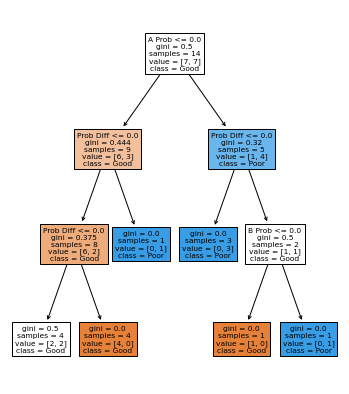

In [7]:
from sklearn.tree import export_text, DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
feature_names = ["Prob Diff", "A Prob", "B Prob"]
tree_rules = export_text(clf, feature_names=feature_names)
# print the result
print(tree_rules)
fig = plt.figure(figsize=(6,7))
_ = tree.plot_tree(clf, feature_names=feature_names, class_names=["Good","Poor"], filled=True)

In [8]:
clf.feature_importances_

array([0.52, 0.28, 0.2 ])

0.6428571428571429
|--- Prob Diff <= 0.00
|   |--- class: 0.0
|--- Prob Diff >  0.00
|   |--- class: 1.0



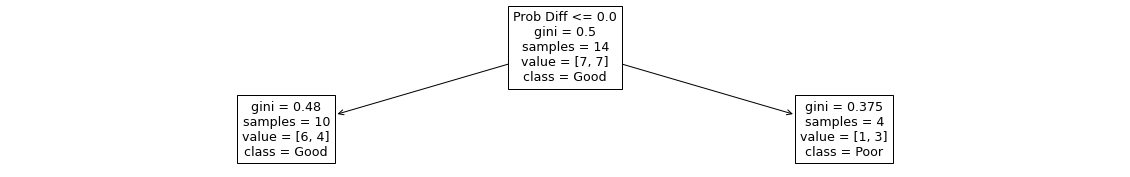

In [9]:
X_train_diff = X_train[:, [0]]
y_train_diff = y_train

clf_diff = DecisionTreeClassifier(max_depth=1)
clf_diff.fit(X_train_diff, y_train_diff)
print(clf_diff.score(X_train_diff, y_train_diff))

feature_names = ["Prob Diff"]
tree_rules_diff = export_text(clf_diff, feature_names=feature_names)
print(tree_rules_diff)
fig_diff = plt.figure(figsize=(20,3))
_ = tree.plot_tree(clf_diff, feature_names=feature_names, class_names=["Good","Poor"])

0.6122448979591837


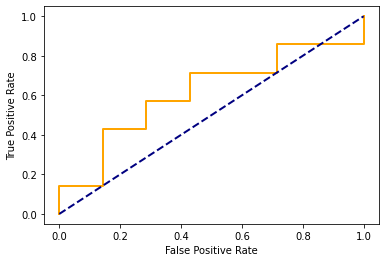

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc

print(roc_auc_score(y_train_diff, X_train_diff))
fpr, tpr, _ = roc_curve(y_train_diff, X_train_diff)
lw = 2
plt.plot(fpr, tpr, color="orange", lw=lw, linestyle="solid")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('thresholdclassification.png',dpi=600)
plt.show()

In [31]:
print(fpr[5], tpr[5])
print(_[5])

0.2857142857142857 0.5714285714285714
3.6521278161671944e-06


In [32]:
from sklearn.metrics import auc

In [12]:
print(confusion_matrix(y_train_diff, X_train_diff < 0.0465,labels=[1,0]))

[[7 0]
 [7 0]]


In [13]:
df = pd.read_excel("../data/gap/MY_DATASET.xlsx")
n = len(df) - 4

X_test = np.zeros((4,3))
y_test = np.zeros(4)

# for index, row in df.sample(frac=1).iterrows():
for index, row in df.iloc[n:].iterrows():
    spacy_doc = nlp(row['Text'])
    doc = Document(tokens=[token.text for token in spacy_doc], speakers=["-" for token in spacy_doc],
               corefs=[], raw_text=None, filename=None, sentences=None)
    # spans, probs, g_clusters, r_clusters, p_clusters = trainer.predict_clusters(doc)
    spans, probs  = trainer.predict_clusters(doc)
    span_tokens = [(idx, doc.tokens[span.i1:span.i2 + 1]) for idx, span in enumerate(spans)]
    a_span_tokens = [span_token for span_token in span_tokens if " ".join(span_token[1]) == row["A"]][0]
    b_span_tokens = [span_token for span_token in span_tokens if " ".join(span_token[1]) == row["B"]][0]
    p_span_tokens = [span_token for span_token in span_tokens if " ".join(span_token[1]) == row["Pronoun"]][0]

    ap_prob = probs[p_span_tokens[0], a_span_tokens[0]]
    bp_prob = probs[p_span_tokens[0], b_span_tokens[0]]
    diff_prob = abs(ap_prob - bp_prob)
    print(row["Text"])
    print("A Prob", ap_prob.item())
    print("B Prob", bp_prob.item())
    print("Prob Diff", diff_prob.item())
    print(probs[p_span_tokens[0]])
    print(torch.argmax(probs[p_span_tokens[0]]).item())
    print()

    index = index - n
    if row["IsPoor"]:
        y_test[index] = 1

    X_test[index, 0] = diff_prob
    X_test[index, 1] = ap_prob
    X_test[index, 2] = bp_prob

Jim and Steve had an argument. He decided to go home.
A Prob 0.03380929306149483
B Prob 0.24214471876621246
Prob Diff 0.20833542943000793
tensor([ 3.3809e-02,  2.0892e-07,  2.4214e-01,  1.4411e-08,  3.1792e-05,
         7.2146e-08,  1.0749e-04,  8.1962e-05,  1.2260e-04,  5.1732e-07,
         1.0271e-09,  1.0690e-03,  1.2738e-07,  2.5153e-02,  1.5203e-08,
         3.5627e-08,  1.0054e-07,  3.7965e-03,  2.1909e-05,  1.2425e-09,
         1.7134e-06,  3.3152e-08,  2.4988e-06,  8.5613e-08,  1.1287e-06,
         1.0929e-04,  3.1290e-08,  2.7038e-05,  6.9352e-01, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10],
       grad_fn=<SelectBackward0>)
28

The boss fired the employee. He was always late to work.
A Prob 0.02691851370036602
B Prob 0.4300943911075

In [14]:
clf.predict(X_test)

array([1., 1., 1., 1.])

In [15]:
df = pd.read_excel("../data/gap/MY_DATASET.xlsx")
n = 4

X_pred = np.zeros((n,3))
y_pred = np.zeros(n)

# for index, row in df.sample(frac=1).iterrows():
count = 0
for index, row in df.iloc[-n:].iterrows():
    spacy_doc = nlp(row['Text'])
    doc = Document(tokens=[token.text for token in spacy_doc], speakers=["-" for token in spacy_doc],
               corefs=[], raw_text=None, filename=None, sentences=None)
    spans, probs, g_clusters, r_clusters, p_clusters = trainer.predict_clusters(doc)
    span_tokens = [(idx, doc.tokens[span.i1:span.i2 + 1]) for idx, span in enumerate(spans)]
    a_span_tokens = [span_token for span_token in span_tokens if " ".join(span_token[1]) == row["A"]][0]
    b_span_tokens = [span_token for span_token in span_tokens if " ".join(span_token[1]) == row["B"]][0]
    p_span_tokens = [span_token for span_token in span_tokens if " ".join(span_token[1]) == row["Pronoun"]][0]

    ap_prob = probs[p_span_tokens[0], a_span_tokens[0]]
    bp_prob = probs[p_span_tokens[0], b_span_tokens[0]]
    diff_prob = abs(ap_prob - bp_prob)
    print(row["Text"])
    print("A Prob", ap_prob.item())
    print("B Prob", bp_prob.item())
    print("Prob Diff", diff_prob.item())
    print()

    if row["IsPoor"]:
        y_pred[count] = 1.

    X_pred[count, 0] = diff_prob
    X_pred[count, 1] = ap_prob
    X_pred[count, 2] = bp_prob

    count += 1

ValueError: not enough values to unpack (expected 5, got 2)

In [16]:
clf.predict(X_pred)

array([0., 0., 0., 0.])

In [17]:
y_pred

array([0., 0., 0., 0.])

In [18]:
clf_diff.predict(X_pred[:, [0]])

array([0., 0., 0., 0.])

In [19]:
y_pred

array([0., 0., 0., 0.])

In [20]:
X_pred[:,0] > 0.046

array([False, False, False, False])

In [21]:
X_train, y_train

(array([[1.43279525e-04, 3.93009941e-06, 1.47209619e-04],
        [3.96651728e-07, 8.73172326e-08, 4.83968961e-07],
        [3.65212782e-06, 3.62905325e-07, 4.01503303e-06],
        [2.19528720e-05, 1.79093809e-06, 2.37438107e-05],
        [1.82900658e-06, 1.84690612e-06, 3.67591269e-06],
        [2.21944811e-06, 1.46102408e-07, 2.36555047e-06],
        [1.18547077e-05, 1.06532163e-07, 1.19612396e-05],
        [1.39829717e-04, 3.25992551e-06, 1.43089637e-04],
        [9.80998482e-09, 9.97827265e-10, 1.08078124e-08],
        [6.64963684e-09, 1.42537937e-09, 8.07501621e-09],
        [1.20580612e-09, 4.82191354e-09, 6.02771966e-09],
        [6.79589230e-15, 1.10291186e-15, 7.89880416e-15],
        [4.20487686e-06, 2.48878877e-07, 4.45375554e-06],
        [1.79221524e-06, 1.17172050e-08, 1.80393249e-06]]),
 array([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.]))

In [22]:
X_train_diff

array([[1.43279525e-04],
       [3.96651728e-07],
       [3.65212782e-06],
       [2.19528720e-05],
       [1.82900658e-06],
       [2.21944811e-06],
       [1.18547077e-05],
       [1.39829717e-04],
       [9.80998482e-09],
       [6.64963684e-09],
       [1.20580612e-09],
       [6.79589230e-15],
       [4.20487686e-06],
       [1.79221524e-06]])

In [23]:
y_train

array([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.])

In [24]:
def calculate_number_correct(probs, targets, threshold):
    preds = (probs >= threshold).flatten()
    return sum(preds == targets)

In [25]:
calculate_number_correct(X_train_diff, y_train, 0.05)

7

In [26]:
for i in range(1,10):
    print(i*0.05)
    print(calculate_number_correct(X_train_diff, y_train, i*0.05))

0.05
7
0.1
7
0.15000000000000002
7
0.2
7
0.25
7
0.30000000000000004
7
0.35000000000000003
7
0.4
7
0.45
7
